In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.datamodule import MSDataModule
from src.model import MSTransformer
from src.constants import MSConstants
C = MSConstants()

In [4]:
dm = MSDataModule(
    hdf_path='./data/ProteomeTools.hdf',
    batch_size=1024,
    train_val_split=0.95,
    cdhit_threshold=0.9,
    cdhit_word_length=5,
    cache_dir='$TMPDIR',
    num_workers=20
)

In [5]:
from src.torch_helpers import start_tensorboard

start_tensorboard(login_node='login-2')

In [6]:
model = MSTransformer(
    residues=C.alphabet,
    ions=C.ions,
    parent_min_charge=C.min_charge,
    parent_max_charge=C.max_charge,
    fragment_min_charge=C.min_frag_charge,
    fragment_max_charge=C.max_frag_charge,
    losses=C.losses,
    model_dim=512,
    model_depth=4,
    num_heads=8,
    lr=1e-4,
    dropout=0.1, 
    max_length=100
)

In [7]:
from pytorch_lightning import Trainer

!rm -rf ./lightning_logs
trainer = Trainer(
    gpus=1,
    max_epochs=50,
    # num_sanity_val_steps=0,
    log_every_n_steps=5
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [GPU-8d15b7a2-1ae5-a612-8955-28d596d85935]
Set SLURM handle signals.

  | Name                | Type               | Params
-----------------------------------------------------------
0 | residue_embedding   | Embedding          | 12.3 K
1 | charge_embedding    | Embedding          | 3.6 K 
2 | ce_embedding        | Sequential         | 512   
3 | positional_encoding | PositionalEncoding | 0     
4 | transformer         | Transformer        | 16.8 M
5 | classifier          | Linear             | 9.2 K 
-----------------------------------------------------------
16.9 M    Trainable params
0         Non-trainable params
16.9 M    Total params
67.433    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [ ]:
dm.setup()
model = model.cpu()
model.eval();

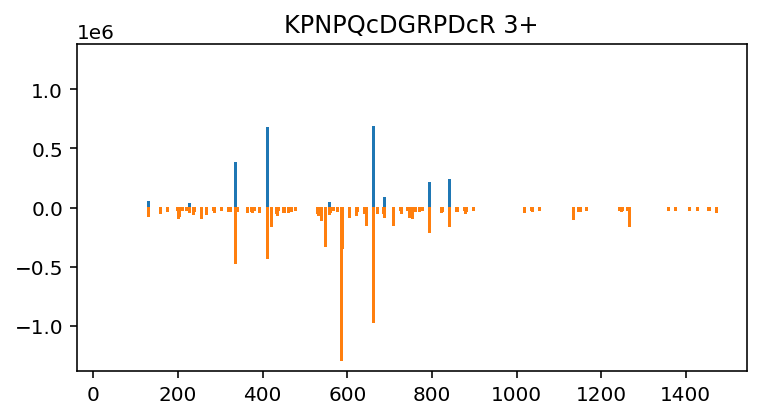

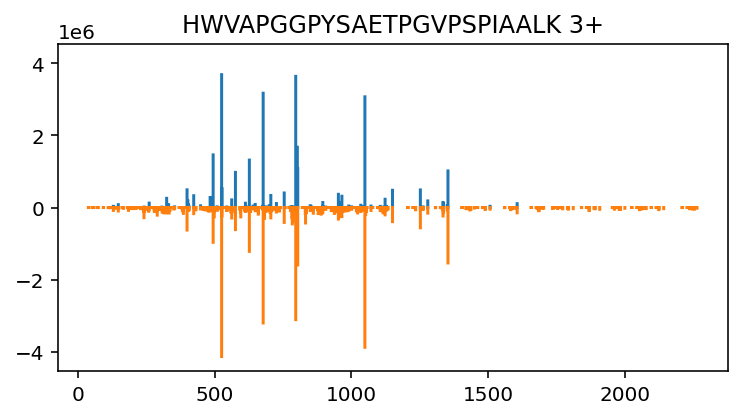

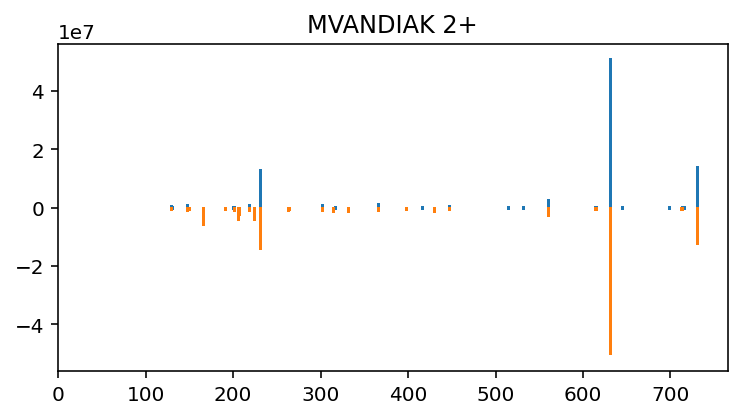

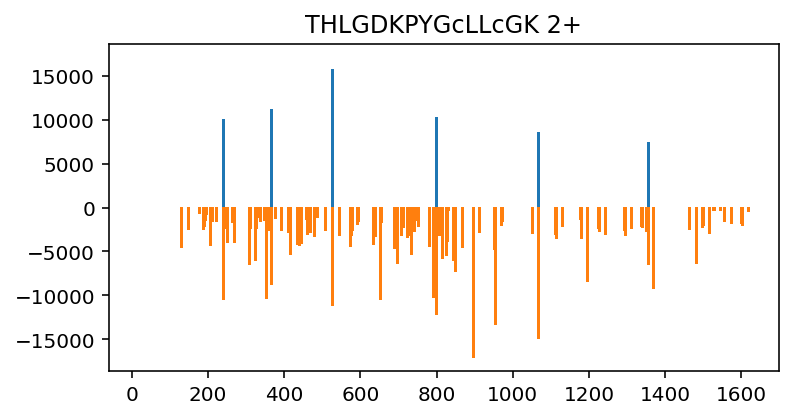

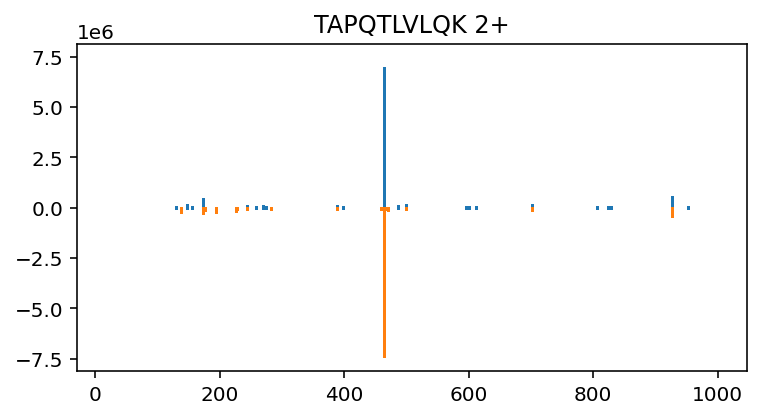

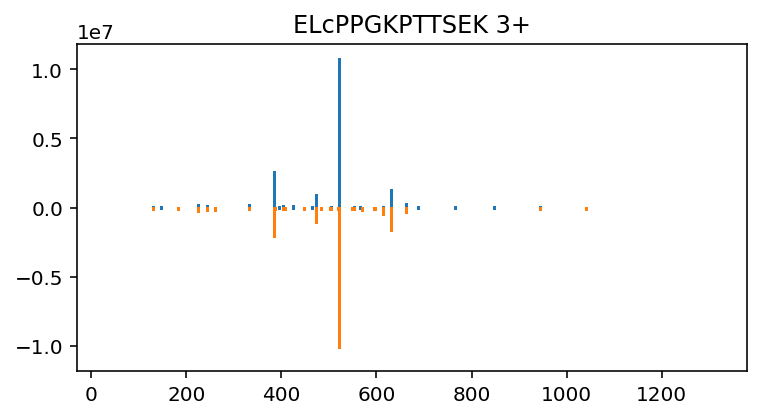

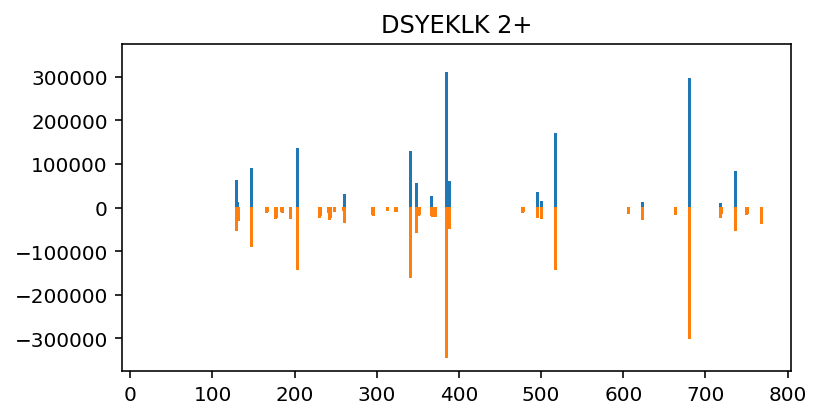

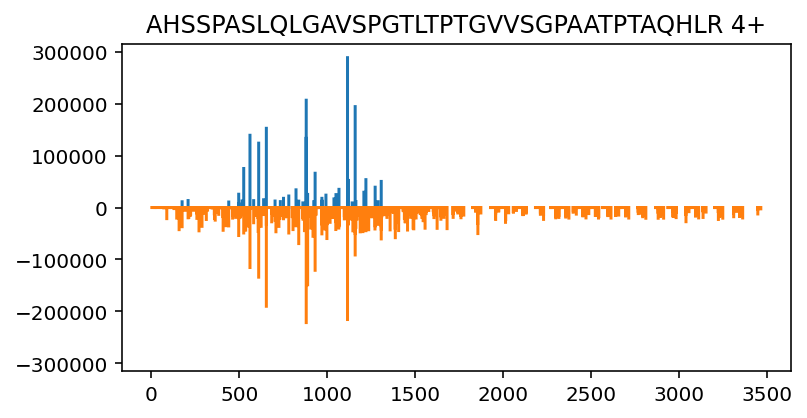

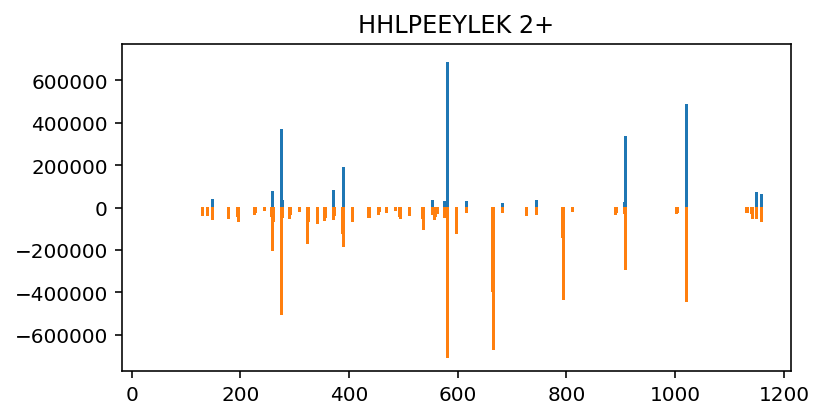

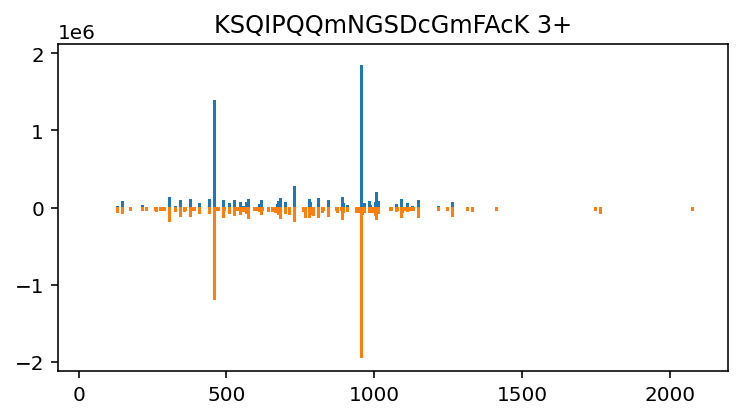

In [19]:
from src.plotting import faststem
from src.spectrum import fragment_mz_tensor

for i, batch in enumerate(dm.predict_dataloader(shuffle=True)):
    if i == 10:
        break
    
    batch['y_pred'] = model.predict_step(batch)

    mz = fragment_mz_tensor(batch['sequence'][0]).ravel()
    y = batch['y'][0].detach().cpu().numpy().ravel()
    y_pred = batch['y_pred'][0].detach().cpu().numpy().ravel()
    
    plt.figure(figsize=(6,3))
    faststem(mz,y)
    faststem(mz,-y_pred)
    yl = max(np.abs(plt.ylim()))
    plt.ylim([-yl,yl])
    plt.title(f"{batch['sequence'][0]} {batch['charge'][0]}+")